# Sector Neutral

## Install packages

In [1]:
import sys

In [2]:
!{sys.executable} -m pip install -r requirements.txt

  Using cached https://files.pythonhosted.org/packages/a5/dc/2f9cd107d0d4cf6223d37d81ddfbbdbf0d703d03669b83810fa6b97f32e5/alphalens-0.3.2.tar.gz
  Using cached https://files.pythonhosted.org/packages/a1/59/2613468ffbbe3a818934d06b81b9f4877fe054afbf4f99d2f43f398a0b34/cvxpy-1.0.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/68/1e/116ad560de97694e2d0c1843a7a0075cc9f49e922454d32f49a80eb6f1f2/numpy-1.14.5-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/11/09/e66eb844daba8680ddff26335d5b4fead77f60f957678243549a8dd4830d/pandas-0.18.1.tar.gz
  Using cached https://files.pythonhosted.org/packages/99/a6/8214b6564bf4ace9bec8a26e7f89832792be582c042c47c912d3201328a0/plotly-2.2.3.tar.gz
  Using cached https://files.pythonhosted.org/packages/d8/5e/caa01ba7be11600b6a9d39265440d7b3be3d69206da887c42bef049521f2/scipy-1.0.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/71/3c/341b4fa23cb3abc335207dba057c790f3

In [5]:
import cvxpy as cvx
import numpy as np
import pandas as pd
import time
import os
import quiz_helper
import matplotlib.pyplot as plt

In [6]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

## following zipline bundle documentation

http://www.zipline.io/bundles.html#ingesting-data-from-csv-files

### data bundle

In [7]:
import os
import quiz_helper
from zipline.data import bundles

In [8]:
os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '..', '..','data','module_4_quizzes_eod')
ingest_func = bundles.csvdir.csvdir_equities(['daily'], quiz_helper.EOD_BUNDLE_NAME)
bundles.register(quiz_helper.EOD_BUNDLE_NAME, ingest_func)
print('Data Registered')

Data Registered


### Build pipeline engine

In [9]:
from zipline.pipeline import Pipeline
from zipline.pipeline.factors import AverageDollarVolume
from zipline.utils.calendars import get_calendar

universe = AverageDollarVolume(window_length=120).top(500) 
trading_calendar = get_calendar('NYSE') 
bundle_data = bundles.load(quiz_helper.EOD_BUNDLE_NAME)
engine = quiz_helper.build_pipeline_engine(bundle_data, trading_calendar)

### View Data¶
With the pipeline engine built, let's get the stocks at the end of the period in the universe we're using. We'll use these tickers to generate the returns data for the our risk model.

In [10]:
universe_end_date = pd.Timestamp('2016-01-05', tz='UTC')

universe_tickers = engine\
    .run_pipeline(
        Pipeline(screen=universe),
        universe_end_date,
        universe_end_date)\
    .index.get_level_values(1)\
    .values.tolist()
    
universe_tickers

[Equity(0 [A]),
 Equity(1 [AAL]),
 Equity(2 [AAP]),
 Equity(3 [AAPL]),
 Equity(4 [ABBV]),
 Equity(5 [ABC]),
 Equity(6 [ABT]),
 Equity(7 [ACN]),
 Equity(8 [ADBE]),
 Equity(9 [ADI]),
 Equity(10 [ADM]),
 Equity(11 [ADP]),
 Equity(12 [ADS]),
 Equity(13 [ADSK]),
 Equity(14 [AEE]),
 Equity(15 [AEP]),
 Equity(16 [AES]),
 Equity(17 [AET]),
 Equity(18 [AFL]),
 Equity(19 [AGN]),
 Equity(20 [AIG]),
 Equity(21 [AIV]),
 Equity(22 [AIZ]),
 Equity(23 [AJG]),
 Equity(24 [AKAM]),
 Equity(25 [ALB]),
 Equity(26 [ALGN]),
 Equity(27 [ALK]),
 Equity(28 [ALL]),
 Equity(29 [ALLE]),
 Equity(30 [ALXN]),
 Equity(31 [AMAT]),
 Equity(32 [AMD]),
 Equity(33 [AME]),
 Equity(34 [AMG]),
 Equity(35 [AMGN]),
 Equity(36 [AMP]),
 Equity(37 [AMT]),
 Equity(38 [AMZN]),
 Equity(39 [ANDV]),
 Equity(40 [ANSS]),
 Equity(41 [ANTM]),
 Equity(42 [AON]),
 Equity(43 [AOS]),
 Equity(44 [APA]),
 Equity(45 [APC]),
 Equity(46 [APD]),
 Equity(47 [APH]),
 Equity(48 [ARE]),
 Equity(49 [ARNC]),
 Equity(50 [ATVI]),
 Equity(51 [AVB]),
 Equity(

# Get Returns data

In [11]:
from zipline.data.data_portal import DataPortal

data_portal = DataPortal(
    bundle_data.asset_finder,
    trading_calendar=trading_calendar,
    first_trading_day=bundle_data.equity_daily_bar_reader.first_trading_day,
    equity_minute_reader=None,
    equity_daily_reader=bundle_data.equity_daily_bar_reader,
    adjustment_reader=bundle_data.adjustment_reader)

## Get pricing data helper function

In [12]:
def get_pricing(data_portal, trading_calendar, assets, start_date, end_date, field='close'):
    end_dt = pd.Timestamp(end_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')
    start_dt = pd.Timestamp(start_date.strftime('%Y-%m-%d'), tz='UTC', offset='C')

    end_loc = trading_calendar.closes.index.get_loc(end_dt)
    start_loc = trading_calendar.closes.index.get_loc(start_dt)

    return data_portal.get_history_window(
        assets=assets,
        end_dt=end_dt,
        bar_count=end_loc - start_loc,
        frequency='1d',
        field=field,
        data_frequency='daily')

## get pricing data into a dataframe

In [13]:
returns_df = \
    get_pricing(
        data_portal,
        trading_calendar,
        universe_tickers,
        universe_end_date - pd.DateOffset(years=5),
        universe_end_date)\
    .pct_change()[1:].fillna(0) #convert prices into returns

returns_df

,Equity(0 [A]),Equity(1 [AAL]),Equity(2 [AAP]),Equity(3 [AAPL]),Equity(4 [ABBV]),Equity(5 [ABC]),Equity(6 [ABT]),Equity(7 [ACN]),Equity(8 [ADBE]),Equity(9 [ADI]),...,Equity(481 [XL]),Equity(482 [XLNX]),Equity(483 [XOM]),Equity(484 [XRAY]),Equity(485 [XRX]),Equity(486 [XYL]),Equity(487 [YUM]),Equity(488 [ZBH]),Equity(489 [ZION]),Equity(490 [ZTS])
2011-01-07 00:00:00+00:00,0.008437,0.014230,0.026702,0.007146,0.000000,0.001994,0.004165,0.001648,-0.007127,-0.005818,...,-0.001838,-0.005619,0.005461,-0.004044,-0.013953,0.000000,0.012457,-0.000181,-0.010458,0.000000
2011-01-10 00:00:00+00:00,-0.004174,0.006195,0.007435,0.018852,0.000000,-0.005714,-0.008896,-0.008854,0.028714,0.002926,...,0.000947,0.007814,-0.006081,0.010466,0.009733,0.000000,0.001440,0.007784,-0.017945,0.000000
2011-01-11 00:00:00+00:00,-0.001886,-0.043644,-0.005927,-0.002367,0.000000,0.009783,-0.002067,0.013717,0.000607,0.008753,...,0.001314,0.010179,0.007442,0.007351,0.006116,0.000000,-0.006470,0.035676,0.007467,0.000000
2011-01-12 00:00:00+00:00,0.017254,-0.008237,0.013387,0.008133,0.000000,-0.005979,-0.001011,0.022969,0.017950,0.000257,...,0.004986,0.015666,0.011763,0.027182,0.004386,0.000000,0.002631,0.014741,-0.011903,0.000000
2011-01-13 00:00:00+00:00,-0.004559,0.000955,0.003031,0.003657,0.000000,0.014925,-0.004451,-0.000400,-0.005719,-0.005012,...,0.030499,-0.003217,0.001694,0.000547,-0.018235,0.000000,-0.005084,-0.004665,-0.009178,0.000000
2011-01-14 00:00:00+00:00,0.003439,-0.009156,0.003022,0.008106,0.000000,0.001395,-0.010111,0.002590,0.012283,0.019827,...,0.026607,0.025894,0.014743,-0.000287,0.026494,0.000000,-0.021661,0.005949,0.033177,0.000000
2011-01-18 00:00:00+00:00,0.034254,-0.062085,-0.004286,-0.022474,0.000000,0.020889,0.006621,0.006998,0.011542,0.032645,...,0.001678,0.002501,0.011163,0.011589,0.006044,0.000000,0.029453,0.006998,-0.008534,0.000000
2011-01-19 00:00:00+00:00,-0.010224,-0.008929,0.008754,-0.005314,0.000000,-0.017144,0.002753,-0.002962,-0.007899,-0.020575,...,-0.014834,-0.023590,-0.005968,-0.019899,-0.012847,0.000000,0.000818,-0.004098,-0.018433,0.000000
2011-01-20 00:00:00+00:00,-0.008496,0.021953,-0.004732,-0.018189,0.000000,0.004794,0.013322,0.018713,-0.012386,-0.002818,...,-0.024512,0.007744,-0.006261,-0.000841,-0.033798,0.000000,-0.013182,-0.001612,-0.007972,0.000000
2011-01-21 00:00:00+00:00,0.007873,-0.041038,0.005544,-0.017911,0.000000,0.010642,-0.000853,-0.001952,-0.006569,-0.004113,...,0.000000,0.000615,0.015825,-0.003048,-0.000872,0.000000,-0.007590,0.009325,0.024020,0.000000


## Sector data helper function
We'll create an object for you, which defines a sector for each stock.  The sectors are represented by integers.  We inherit from the Classifier class.  [Documentation for Classifier](https://www.quantopian.com/posts/pipeline-classifiers-are-here), and the [source code for Classifier](https://github.com/quantopian/zipline/blob/master/zipline/pipeline/classifiers/classifier.py)

In [14]:
from zipline.pipeline.classifiers import Classifier
from zipline.utils.numpy_utils import int64_dtype
class Sector(Classifier):
    dtype = int64_dtype
    window_length = 0
    inputs = ()
    missing_value = -1

    def __init__(self):
        self.data = np.load('../../data/project_4_sector/data.npy')

    def _compute(self, arrays, dates, assets, mask):
        return np.where(
            mask,
            self.data[assets],
            self.missing_value,
        )

In [15]:
sector = Sector()
sector

Sector((), window_length=0)

In [16]:
len(sector.data)

491

In [17]:
sector.data

array([ 0,  3,  8,  1,  0,  0,  0,  1,  1,  1,  2,  3,  5,  1,  4,  4,  4,
        0,  5,  0,  5,  6,  5,  5,  1, 10,  0,  3,  5,  3,  0,  1,  1,  3,
        5,  0,  5,  7,  8,  9,  1,  0,  5,  3,  9,  9, 10,  1,  6,  3,  1,
        6,  1,  3,  4,  5,  1,  8,  3,  5,  0,  5,  8,  0,  0,  5,  0,  5,
        5,  8,  0,  0,  8,  6,  5,  1,  2,  0,  3,  5,  6,  5,  8,  6,  8,
        0,  1, 10,  5,  2,  9,  3,  7,  0,  5,  2,  2,  5,  7,  5,  8,  3,
        4,  0,  4,  5,  9,  3,  0,  9,  2,  2,  2,  1,  1,  1,  3,  3,  7,
        1,  1,  0,  9,  9,  4,  3,  3,  5,  2,  0,  8,  0,  8,  8, -1,  7,
        6,  2,  3,  2,  6,  8,  4,  4,  0,  9,  1,  8, 10,  4,  3,  4,  2,
       10,  3,  9,  6,  6,  9,  4,  0,  6,  5,  3,  4,  0,  0,  4,  3,  8,
        6,  8,  3,  1,  8, 10,  3,  4,  1,  3,  3,  5,  8,  1,  3,  3, 10,
        8, -1,  6,  9,  3,  3,  6,  0,  2,  1,  8, -1,  1,  8,  3,  8,  1,
        5,  8,  3,  9,  8,  5,  8,  0,  6,  6,  8,  9,  5,  8,  8,  0,  3,
        9,  1,  1,  8,  2

## Quiz 1
How many unique sectors are in the sector variable?

## Answer

11


## Create an alpha factor based on momentum

We want to calculate the one-year return.  
In other words, get the close price of today, minus the close price of 252 trading days ago, and divide by that price from 252 days ago.

$1YearReturn_t = \frac{price_{t} - price_{t-252}}{price_{t-252}}$

In [18]:
from zipline.pipeline.factors import Returns

## We'll use 2 years of data to calculate the factor

**Note:** Going back 2 years falls on a day when the market is closed. Pipeline package doesn't handle start or end dates that don't fall on days when the market is open. To fix this, we went back 2 extra days to fall on the next day when the market is open.

In [19]:
factor_start_date = universe_end_date - pd.DateOffset(years=2, days=2)
factor_start_date

Timestamp('2014-01-03 00:00:00+0000', tz='UTC')

In [20]:
## 1 year returns can be the basis for an alpha factor
p1 = Pipeline(screen=universe)
rets1 = Returns(window_length=252, mask=universe)
p1.add(rets1,"1YearReturns")
df1 = engine.run_pipeline(p1, factor_start_date, universe_end_date)

In [21]:
#graphviz lets us visualize the pipeline
import graphviz

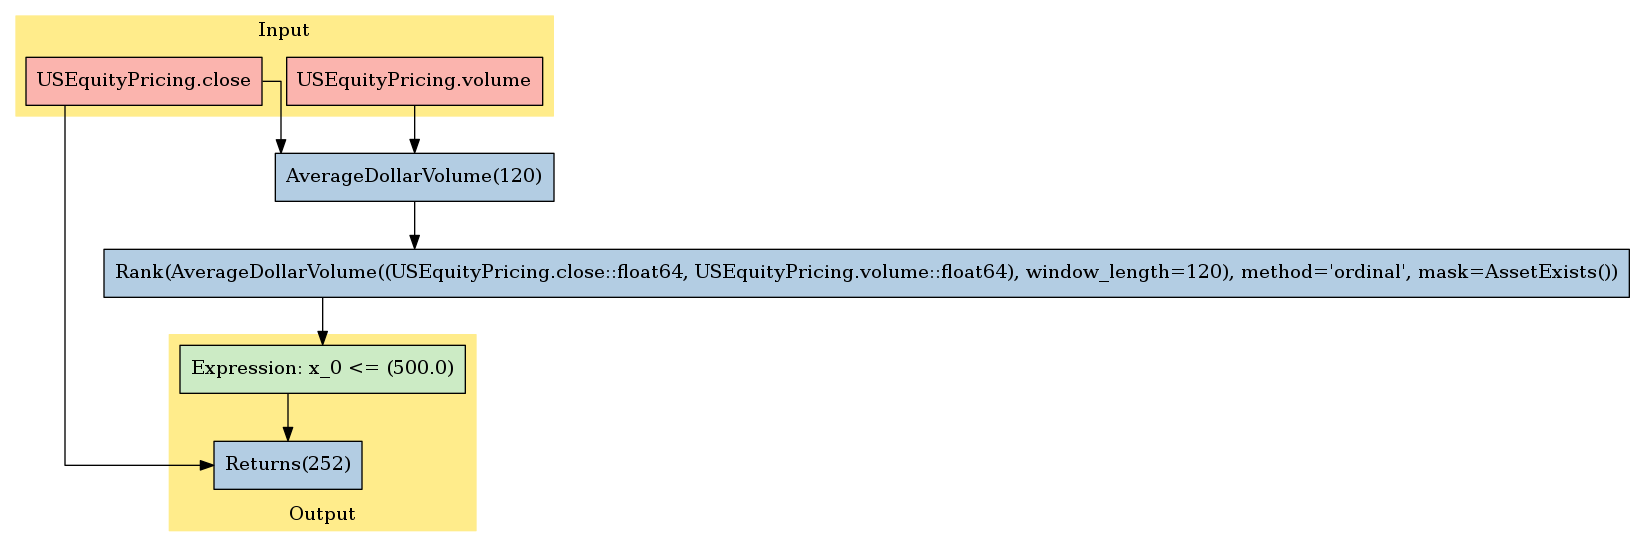

In [22]:
p1.show_graph(format='png')

## View the data of the factor

In [23]:
df1.head()

1YearReturns
2014-01-03 00:00:00+00:00 Equity(0 [A])         0.799433
                          Equity(1 [AAL])       0.856600
                          Equity(2 [AAP])       0.518050
                          Equity(3 [AAPL])      0.045903
                          Equity(4 [ABBV])      0.551403

## Explore the demean function

The Returns class inherits from zipline.pipeline.factors.factor.  
[The documentation for demean is located here](https://www.zipline.io/appendix.html#zipline.pipeline.factors.Factor.demean), and is also pasted below:

```
demean(mask=sentinel('NotSpecified'), groupby=sentinel('NotSpecified'))[source]
Construct a Factor that computes self and subtracts the mean from row of the result.

If mask is supplied, ignore values where mask returns False when computing row means, and output NaN anywhere the mask is False.

If groupby is supplied, compute by partitioning each row based on the values produced by groupby, de-meaning the partitioned arrays, and stitching the sub-results back together.

Parameters:	
mask (zipline.pipeline.Filter, optional) – A Filter defining values to ignore when computing means.
groupby (zipline.pipeline.Classifier, optional) – A classifier defining partitions over which to compute means.
```

## Quiz 2

By looking at the documentation, and then the source code for `demean`, what are two parameters for this function?  Which one or ones would you call if you wanted to demean by sector and wish to demean for all values in the chosen universe?

[The source code](https://www.zipline.io/_modules/zipline/pipeline/factors/factor.html#Factor.demean) has useful comments to help you answer this question.

### Answer

The two parameters are groupby and mask, if you wanted to demean by sector you would supply groupby with a classifer of each sector and would not supply a mask if you wanted all the values. 

## Quiz 3
Turn 1 year returns into an alpha factor

We can do some processing to convert our signal (1 year return) into an alpha factor. One step is to demean by sector.

* demean
For each stock, we want to take the average return of stocks that are in the same sector, and then remove this from the return of each individual stock.

## Answer 3

In [28]:
# create a pipeline called p2
p2 = Pipeline(screen=universe)

# create a factor of one year returns, demean by sector
rets2 = Returns(window_length=252).demean(groupby=sector)

# add the factor to the p2 pipeline
p2.add(rets2, 'DemeanSector')

## visualize the second pipeline

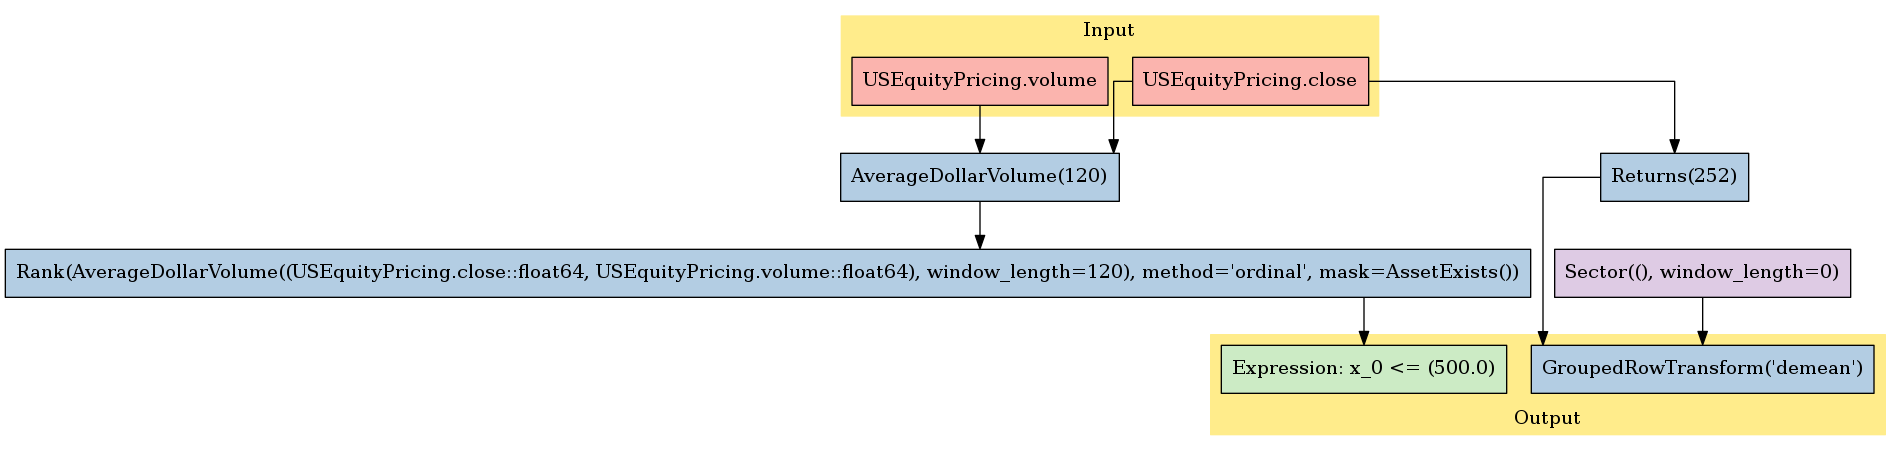

In [29]:
p2.show_graph(format='png')

## Quiz 4
How does this pipeline compare with the first pipeline that we created earlier?

### Answer

We are now demaning the returns by sector mean


## run pipeline and view the factor data

In [30]:
df2 = engine.run_pipeline(p2, factor_start_date, universe_end_date)

In [31]:
df2.head()

DemeanSector
2014-01-03 00:00:00+00:00 Equity(0 [A])         0.368412
                          Equity(1 [AAL])       0.473351
                          Equity(2 [AAP])       0.030409
                          Equity(3 [AAPL])     -0.345754
                          Equity(4 [ABBV])      0.120381